In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("shopping_trends.csv").filter(['Age','Frequency of Purchases'])
print(df)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
print(train_df, test_df)

      Age Frequency of Purchases
0      55            Fortnightly
1      19            Fortnightly
2      50                 Weekly
3      21                 Weekly
4      45               Annually
...   ...                    ...
3895   40                 Weekly
3896   52              Bi-Weekly
3897   46              Quarterly
3898   44                 Weekly
3899   52              Quarterly

[3900 rows x 2 columns]
      Age Frequency of Purchases
1370   27         Every 3 Months
1474   31                Monthly
2053   19            Fortnightly
2829   56                 Weekly
279    23                Monthly
...   ...                    ...
1130   67              Bi-Weekly
1294   27         Every 3 Months
860    26                Monthly
3507   46         Every 3 Months
3174   45                Monthly

[3510 rows x 2 columns]       Age Frequency of Purchases
839    48         Every 3 Months
1717   29              Bi-Weekly
321    41              Quarterly
3187   67                 

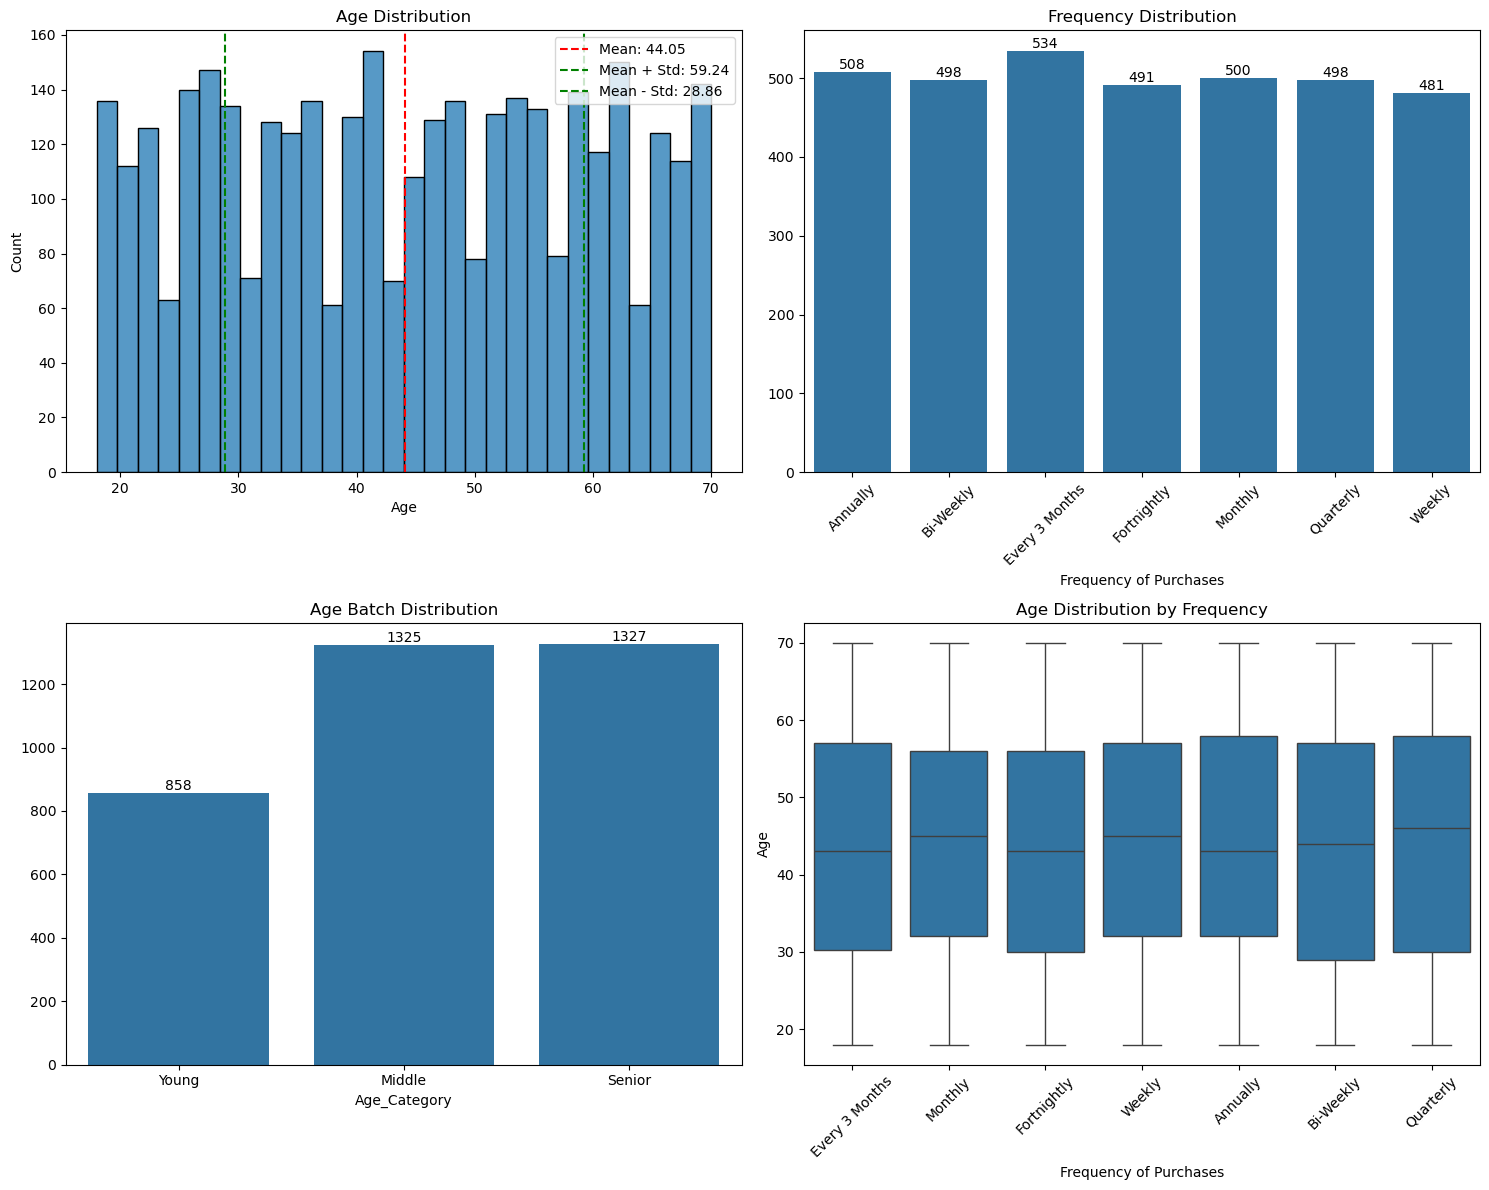


Age Statistics:
Mean: 44.05
Standard Deviation: 15.19
Min: 18
Max: 70

Frequency distribution by Age Category:
Frequency of Purchases  Annually  Bi-Weekly  Every 3 Months  Fortnightly  \
Age_Category                                                               
Young                        114        140             134          127   
Middle                       199        173             211          184   
Senior                       195        185             189          180   

Frequency of Purchases  Monthly  Quarterly  Weekly  
Age_Category                                        
Young                       111        130     102  
Middle                      202        161     195  
Senior                      187        207     184  

Frequency Distribution:
Frequency of Purchases
Annually          508
Bi-Weekly         498
Every 3 Months    534
Fortnightly       491
Monthly           500
Quarterly         498
Weekly            481
Name: count, dtype: int64


In [5]:
# Tạo figure với 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Phân phối của Age
sns.histplot(data=train_df, x='Age', bins=30, ax=ax1)
ax1.set_title('Age Distribution')
ax1.axvline(train_df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["Age"].mean():.2f}')
ax1.axvline(train_df['Age'].mean() + train_df['Age'].std(), color='green', linestyle='--', 
            label=f'Mean + Std: {train_df["Age"].mean() + train_df["Age"].std():.2f}')
ax1.axvline(train_df['Age'].mean() - train_df['Age'].std(), color='green', linestyle='--',
            label=f'Mean - Std: {train_df["Age"].mean() - train_df["Age"].std():.2f}')
ax1.legend()

# Plot 2: Phân phối của Frequency
freq_counts = train_df['Frequency of Purchases'].value_counts().sort_index()
sns.barplot(x=freq_counts.index, y=freq_counts.values, ax=ax2)
ax2.set_title('Frequency Distribution')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(freq_counts.values):
    ax2.text(i, v, str(v), ha='center', va='bottom')

# Tạo df mới với age batch
train_df_batch = train_df.copy()
train_df_batch['Age_Category'] = pd.cut(train_df_batch['Age'], 
                                      bins=[0, 30, 50, float('inf')],
                                      labels=['Young', 'Middle', 'Senior'])

# Plot 3: Phân phối của Age Batch
age_batch_counts = train_df_batch['Age_Category'].value_counts().sort_index()
sns.barplot(x=age_batch_counts.index, y=age_batch_counts.values, ax=ax3)
ax3.set_title('Age Batch Distribution')
for i, v in enumerate(age_batch_counts.values):
    ax3.text(i, v, str(v), ha='center', va='bottom')

# Plot 4: Boxplot của Age theo Frequency
sns.boxplot(data=train_df, x='Frequency of Purchases', y='Age', ax=ax4)
ax4.set_title('Age Distribution by Frequency')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# In thống kê về Age
print("\nAge Statistics:")
print(f"Mean: {train_df['Age'].mean():.2f}")
print(f"Standard Deviation: {train_df['Age'].std():.2f}")
print(f"Min: {train_df['Age'].min()}")
print(f"Max: {train_df['Age'].max()}")

# In phân phối của Frequency of Purchases theo Age Category
print("\nFrequency distribution by Age Category:")
print(pd.crosstab(train_df_batch['Age_Category'], train_df_batch['Frequency of Purchases']))

# In phân phối của Frequency
print("\nFrequency Distribution:")
print(freq_counts)

In [7]:
def train_discrete_model(train_df, alpha=1.0):
    # Calculate priors P(Frequency)
    freq_counts = train_df['Frequency of Purchases'].value_counts()
    priors = freq_counts / len(train_df)
    
    # Calculate likelihoods P(Age|Frequency) with Laplace smoothing
    likelihoods = {}
    unique_ages = train_df['Age'].unique()
    
    for freq in freq_counts.index:
        freq_data = train_df[train_df['Frequency of Purchases'] == freq]
        age_counts = freq_data['Age'].value_counts()
        
        # Apply Laplace smoothing
        smoothed_counts = {age: alpha for age in unique_ages}  # Initialize with alpha
        smoothed_counts.update(age_counts)  # Update with actual counts
        
        # Calculate probabilities
        total = sum(smoothed_counts.values())
        likelihoods[freq] = {age: count/total for age, count in smoothed_counts.items()}
    
    return priors, likelihoods

def predict_discrete(age, priors, likelihoods):
    posteriors = {}
    for freq, prior in priors.items():
        likelihood = likelihoods[freq].get(age, 0)  # Get likelihood for this age
        posteriors[freq] = prior * likelihood
    
    # Normalize posteriors
    total = sum(posteriors.values())
    if total > 0:  # Avoid division by zero
        posteriors = {k: v/total for k, v in posteriors.items()}
    
    # Return frequency with highest posterior
    return max(posteriors.items(), key=lambda x: x[1])[0]

# Train model
priors, likelihoods = train_discrete_model(train_df)

# Test model
correct = 0
for _, row in test_df.iterrows():
    prediction = predict_discrete(row['Age'], priors, likelihoods)
    if prediction == row['Frequency of Purchases']:
        correct += 1

accuracy = correct / len(test_df)
print(f"Discrete Model Accuracy: {accuracy:.4f}")

Discrete Model Accuracy: 0.1615


In [8]:
from scipy.stats import norm

def train_normal_model(train_df):
   # Tính parameters của normal distribution cho mỗi frequency
   models = {}
   for freq in train_df['Frequency of Purchases'].unique():
       ages = train_df[train_df['Frequency of Purchases'] == freq]['Age']
       mean = ages.mean()
       std = ages.std()
       models[freq] = {'mean': mean, 'std': std}
   
   # Tính priors P(Frequency)
   freq_counts = train_df['Frequency of Purchases'].value_counts()
   priors = freq_counts / len(train_df)
   
   return priors, models

def predict_normal(age, priors, models):   
   posteriors = {}
   for freq, prior in priors.items():
       mean = models[freq]['mean']
       std = models[freq]['std']
       likelihood = norm.pdf(age, mean, std)
       posteriors[freq] = prior * likelihood
   
   # Normalize và return frequency có posterior cao nhất
   total = sum(posteriors.values())
   if total > 0:
       posteriors = {k: v/total for k, v in posteriors.items()}
   return max(posteriors.items(), key=lambda x: x[1])[0]

# Train và test
priors, models = train_normal_model(train_df)
correct = 0
for _, row in test_df.iterrows():
   prediction = predict_normal(row['Age'], priors, models)
   if prediction == row['Frequency of Purchases']:
       correct += 1

accuracy = correct / len(test_df)
print(f"Normal Distribution Model Accuracy: {accuracy:.4f}")

Normal Distribution Model Accuracy: 0.1359


In [9]:
def train_batch_model(train_df):
   # Tạo age categories
   train_df['Age_Category'] = pd.cut(train_df['Age'], 
                                   bins=[0, 30, 50, float('inf')],
                                   labels=['Young', 'Middle', 'Senior'])
   
   # Tính priors P(Frequency)
   freq_counts = train_df['Frequency of Purchases'].value_counts()
   priors = freq_counts / len(train_df)
   
   # Tính likelihoods P(Age_Category|Frequency)
   likelihoods = {}
   for freq in freq_counts.index:
       freq_data = train_df[train_df['Frequency of Purchases'] == freq]
       age_cat_counts = freq_data['Age_Category'].value_counts()
       total = len(freq_data)
       likelihoods[freq] = age_cat_counts / total
   
   return priors, likelihoods

def predict_batch(age, priors, likelihoods):
   # Convert age to category
   if age < 30:
       age_cat = 'Young'
   elif age < 50:
       age_cat = 'Middle'
   else:
       age_cat = 'Senior'
   
   # Tính posteriors
   posteriors = {}
   for freq, prior in priors.items():
       likelihood = likelihoods[freq].get(age_cat, 0)
       posteriors[freq] = prior * likelihood
   
   total = sum(posteriors.values())
   if total > 0:
       posteriors = {k: v/total for k, v in posteriors.items()}
   return max(posteriors.items(), key=lambda x: x[1])[0]

# Train và test
priors, likelihoods = train_batch_model(train_df)
correct = 0
for _, row in test_df.iterrows():
   prediction = predict_batch(row['Age'], priors, likelihoods)
   if prediction == row['Frequency of Purchases']:
       correct += 1

accuracy = correct / len(test_df)
print(f"Batch Model Accuracy: {accuracy:.4f}")

Batch Model Accuracy: 0.1641


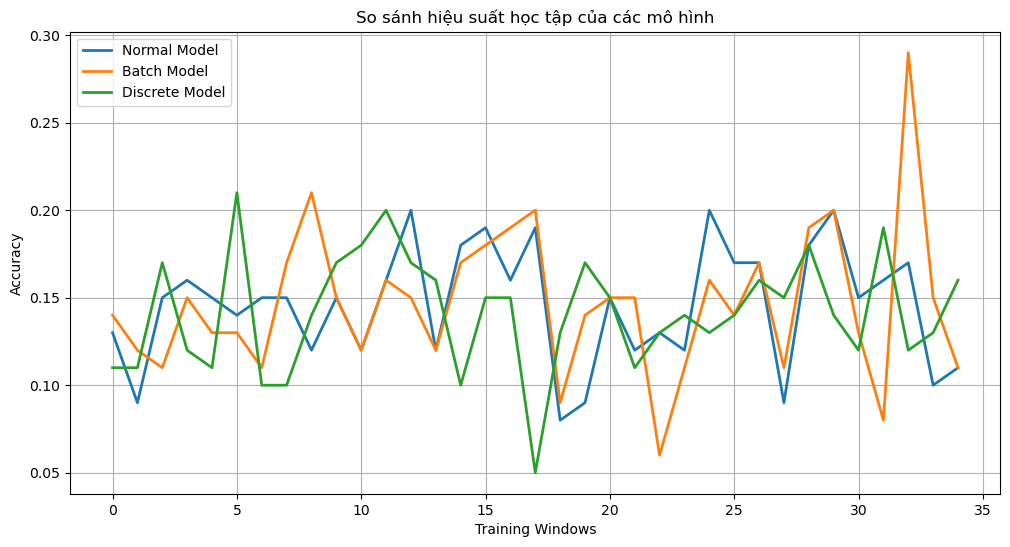


Kết quả đánh giá cuối cùng:
Độ chính xác mô hình Normal: 0.1359
Độ chính xác mô hình Batch: 0.1641
Độ chính xác mô hình Discrete: 0.1590


In [15]:
class BayesianModelBase:
    def __init__(self):
        self.age_stats = {}  # Lưu thống kê về tuổi cho mỗi tần suất
        self.frequency_priors = {}  # Lưu prior probabilities
        self.total_observations = 0
        
    def update_stats(self, age, frequency):
        """Cập nhật thống kê cho một quan sát mới"""
        self.total_observations += 1
        
        if frequency not in self.frequency_priors:
            self.frequency_priors[frequency] = 0
            self.age_stats[frequency] = {'sum': 0, 'sum_squared': 0, 'count': 0}
        
        self.frequency_priors[frequency] += 1
        stats = self.age_stats[frequency]
        stats['sum'] += age
        stats['sum_squared'] += age * age
        stats['count'] += 1
        
    def get_distribution_params(self, frequency):
        """Lấy tham số phân phối cho một tần suất cụ thể"""
        stats = self.age_stats[frequency]
        mean = stats['sum'] / stats['count']
        variance = (stats['sum_squared'] / stats['count']) - (mean * mean)
        std = max(np.sqrt(variance), 1e-6)
        return mean, std

# Mô hình phân phối chuẩn với cập nhật online
class OnlineNormalModel(BayesianModelBase):
    def train(self, age, frequency):
        """Huấn luyện mô hình với một quan sát mới"""
        self.update_stats(age, frequency)
        
    def predict(self, age):
        """Dự đoán tần suất dựa trên tuổi với niềm tin hiện tại"""
        if not self.frequency_priors:
            return None
            
        posteriors = {}
        for freq in self.frequency_priors:
            # Tính prior probability
            prior = self.frequency_priors[freq] / self.total_observations
            
            # Tính likelihood using normal distribution
            mean, std = self.get_distribution_params(freq)
            likelihood = norm.pdf(age, mean, std)
            
            # Tính posterior
            posteriors[freq] = prior * likelihood
            
        # Normalize và return kết quả
        total = sum(posteriors.values())
        if total > 0:
            posteriors = {k: v/total for k, v in posteriors.items()}
            return max(posteriors.items(), key=lambda x: x[1])[0]
        return None

# Mô hình phân nhóm với cập nhật online
class OnlineBatchModel(BayesianModelBase):
    def __init__(self):
        super().__init__()
        self.age_categories = ['Young', 'Middle', 'Senior']
        self.category_stats = {cat: {} for cat in self.age_categories}
        
    def get_age_category(self, age):
        """Xác định nhóm tuổi"""
        if age < 30:
            return 'Young'
        elif age < 50:
            return 'Middle'
        return 'Senior'
        
    def train(self, age, frequency):
        """Huấn luyện mô hình với một quan sát mới"""
        self.update_stats(age, frequency)
        
        # Cập nhật thống kê cho nhóm tuổi
        age_cat = self.get_age_category(age)
        if frequency not in self.category_stats[age_cat]:
            self.category_stats[age_cat][frequency] = 0
        self.category_stats[age_cat][frequency] += 1
        
    def predict(self, age):
        """Dự đoán tần suất dựa trên nhóm tuổi"""
        if not self.frequency_priors:
            return None
            
        age_cat = self.get_age_category(age)
        posteriors = {}
        
        for freq in self.frequency_priors:
            # Tính prior probability
            prior = self.frequency_priors[freq] / self.total_observations
            
            # Tính likelihood cho nhóm tuổi
            cat_count = self.category_stats[age_cat].get(freq, 0)
            total_freq = self.frequency_priors[freq]
            likelihood = (cat_count + 1) / (total_freq + len(self.age_categories))
            
            # Tính posterior
            posteriors[freq] = prior * likelihood
            
        # Normalize và return kết quả
        total = sum(posteriors.values())
        if total > 0:
            posteriors = {k: v/total for k, v in posteriors.items()}
            return max(posteriors.items(), key=lambda x: x[1])[0]
        return None

# Mô hình rời rạc với cập nhật online
class OnlineDiscreteModel(BayesianModelBase):
    def __init__(self, alpha=1.0):
        """Khởi tạo mô hình Discrete với tham số smoothing alpha"""
        super().__init__()
        self.alpha = alpha
        self.age_frequency_counts = {}
        
    def train(self, age, frequency):
        """Huấn luyện mô hình với một quan sát mới"""
        self.update_stats(age, frequency)
        
        if age not in self.age_frequency_counts:
            self.age_frequency_counts[age] = {}
        
        if frequency not in self.age_frequency_counts[age]:
            self.age_frequency_counts[age][frequency] = 0
            
        self.age_frequency_counts[age][frequency] += 1
        
    def predict(self, age):
        """Dự đoán tần suất mua hàng dựa trên tuổi"""
        if not self.frequency_priors:
            return None
            
        posteriors = {}
        
        for freq in self.frequency_priors:
            # Tính prior probability
            prior = self.frequency_priors[freq] / self.total_observations
            
            # Tính likelihood với Laplace smoothing
            if age in self.age_frequency_counts:
                count = self.age_frequency_counts[age].get(freq, 0)
                total = sum(self.age_frequency_counts[age].values())
            else:
                count = 0
                total = 0
                
            likelihood = (count + self.alpha) / (total + self.alpha * len(self.frequency_priors))
            posteriors[freq] = prior * likelihood
            
        # Normalize và return kết quả
        total = sum(posteriors.values())
        if total > 0:
            posteriors = {k: v/total for k, v in posteriors.items()}
            return max(posteriors.items(), key=lambda x: x[1])[0]
        return None

def evaluate_online_model(model, train_data, test_data, window_size=100):
    """Đánh giá hiệu suất của mô hình online"""
    accuracies = []
    current_window = []
    
    # Đảm bảo chỉ làm việc với hai cột cần thiết
    train_ages = train_data['Age'].values
    train_freqs = train_data['Frequency of Purchases'].values
    
    # Huấn luyện và đánh giá từng bước
    for idx in range(len(train_ages)):
        age = train_ages[idx]
        freq = train_freqs[idx]
        
        if idx > 0:
            pred = model.predict(age)
            if pred is not None:
                current_window.append(pred == freq)
                
                if len(current_window) >= window_size:
                    accuracies.append(np.mean(current_window))
                    current_window = []
        
        model.train(age, freq)
    
    # Đánh giá trên tập test
    test_predictions = []
    test_ages = test_data['Age'].values
    test_freqs = test_data['Frequency of Purchases'].values
    
    for idx in range(len(test_ages)):
        pred = model.predict(test_ages[idx])
        if pred is not None:
            test_predictions.append(pred == test_freqs[idx])
    
    final_accuracy = np.mean(test_predictions) if test_predictions else 0
    
    return accuracies, final_accuracy


# Khởi tạo và đánh giá các mô hình
normal_model = OnlineNormalModel()
batch_model = OnlineBatchModel()
discrete_model = OnlineDiscreteModel(alpha=1.0)

# Đánh giá các mô hình
normal_accuracies, normal_final = evaluate_online_model(normal_model, train_df, test_df)
batch_accuracies, batch_final = evaluate_online_model(batch_model, train_df, test_df)
discrete_accuracies, discrete_final = evaluate_online_model(discrete_model, train_df, test_df)

# Visualize kết quả học tập
plt.figure(figsize=(12, 6))
plt.plot(normal_accuracies, label='Normal Model', linewidth=2)
plt.plot(batch_accuracies, label='Batch Model', linewidth=2)
plt.plot(discrete_accuracies, label='Discrete Model', linewidth=2)
plt.xlabel('Training Windows')
plt.ylabel('Accuracy')
plt.title('So sánh hiệu suất học tập của các mô hình')
plt.legend()
plt.grid(True)
plt.show()

# In kết quả cuối cùng
print("\nKết quả đánh giá cuối cùng:")
print(f"Độ chính xác mô hình Normal: {normal_final:.4f}")
print(f"Độ chính xác mô hình Batch: {batch_final:.4f}")
print(f"Độ chính xác mô hình Discrete: {discrete_final:.4f}")